In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from router_utils import (
    get_gen_str,
    short_model_name,
    load_model_data,
    get_latest_probe_preds,
    merge_probe_predictions,
    compute_tier_costs,
    route_cascade_threshold,
    route_random,
    route_oracle_cascade,
    build_cascade_comparison_data,
    plot_cost_vs_accuracy_cascade,
    plot_probe_histograms,
    dataset_title,
)

## Threshold-Based Cascade Routing

The cascade strategy works as follows:
1. Start with the **cheapest** model in the cascade.
2. If the probe confidence is **≤ threshold**, escalate to the next model.
3. Repeat until either a model is confident enough, or we reach the **final fallback** (most expensive model, no probe needed).

This lets us use cheap models for easy problems while only paying for expensive thinking when the probe signals uncertainty.

In [2]:
# ── Configuration ──────────────────────────────────────────
ROUTED_DATASET   = "DigitalLearningGmbH_MATH-lighteval"
PROBE_MODEL_TYPE = "linear_eoi_probe"
CHOSEN_METRIC    = "majority_vote_is_correct"
DATA_DIR         = "../data"

# Models ordered cheapest → most expensive.
# The LAST model is the final fallback (no probe needed).
CASCADE_MODELS = [
    "Qwen/Qwen2.5-Math-7B-Instruct",
    "openai/gpt-oss-20b_medium",
]

print(f"Dataset : {ROUTED_DATASET}")
print(f"Probe   : {PROBE_MODEL_TYPE}")
print(f"Metric  : {CHOSEN_METRIC}")
print(f"\nCascade ({len(CASCADE_MODELS)} models, cheapest → most expensive):")
for i, m in enumerate(CASCADE_MODELS):
    print(f"  {i+1}. {m}: {get_gen_str(m)}")

Dataset : DigitalLearningGmbH_MATH-lighteval
Probe   : linear_eoi_probe
Metric  : majority_vote_is_correct

Cascade (2 models, cheapest → most expensive):
  1. Qwen/Qwen2.5-Math-7B-Instruct: maxlen_3000_k_5_temp_0.7
  2. openai/gpt-oss-20b_medium: maxlen_131072_k_5_temp_1.0


In [3]:
# ── Load test / train data ─────────────────────────────────
test_dfs, train_dfs = {}, {}

for model in CASCADE_MODELS:
    t, tr = load_model_data(model, ROUTED_DATASET, DATA_DIR)
    if t is not None:
        test_dfs[model], train_dfs[model] = t, tr
        print(f"✓ {model}: {len(t)} test, {len(tr)} train")

print(f"\n✓ Loaded {len(test_dfs)}/{len(CASCADE_MODELS)} models")

✓ Qwen/Qwen2.5-Math-7B-Instruct: 5000 test, 6000 train
✓ openai/gpt-oss-20b_medium: 5000 test, 4800 train

✓ Loaded 2/2 models


In [4]:
# ── Load & merge probe predictions ─────────────────────────
# Probes are loaded for all models EXCEPT the last (final fallback).
test_dfs_with_probes = {}

for model in CASCADE_MODELS[:-1]:
    gen_str = get_gen_str(model)
    preds = get_latest_probe_preds(
        ROUTED_DATASET, model, gen_str,
        probe_model_type=PROBE_MODEL_TYPE,
        chosen_metric=CHOSEN_METRIC,
        data_dir=DATA_DIR,
    )
    if preds is not None:
        test_dfs_with_probes[model] = merge_probe_predictions(test_dfs[model], preds)
        pp = test_dfs_with_probes[model]["probe_pred"]
        print(f"  ✓ {model}: {len(pp)} rows, pred ∈ [{pp.min():.4f}, {pp.max():.4f}]")

# Last model used as-is (no probe)
test_dfs_with_probes[CASCADE_MODELS[-1]] = test_dfs[CASCADE_MODELS[-1]].copy()
print(f"  ✓ {CASCADE_MODELS[-1]}: fallback (no probe)")
print(f"\n✓ {len(test_dfs_with_probes)} models ready")

✓ Loading probes for Qwen/Qwen2.5-Math-7B-Instruct from: 20260205_134741
  ✓ Qwen/Qwen2.5-Math-7B-Instruct: 5000 rows, pred ∈ [0.0266, 0.9991]
  ✓ openai/gpt-oss-20b_medium: fallback (no probe)

✓ 2 models ready


In [5]:
# ── Compute tier costs ─────────────────────────────────────
tier_costs, tier_costs_normalized = compute_tier_costs(CASCADE_MODELS, train_dfs)

print("Tier costs (avg total_output_cost_usd):")
for i, m in enumerate(CASCADE_MODELS, 1):
    print(f"  {i}. {m.split('/')[-1]:30s}  ${tier_costs[m]:.6f}")

Tier costs (avg total_output_cost_usd):
  1. Qwen2.5-Math-7B-Instruct        $0.000682
  2. gpt-oss-20b_medium              $0.002854


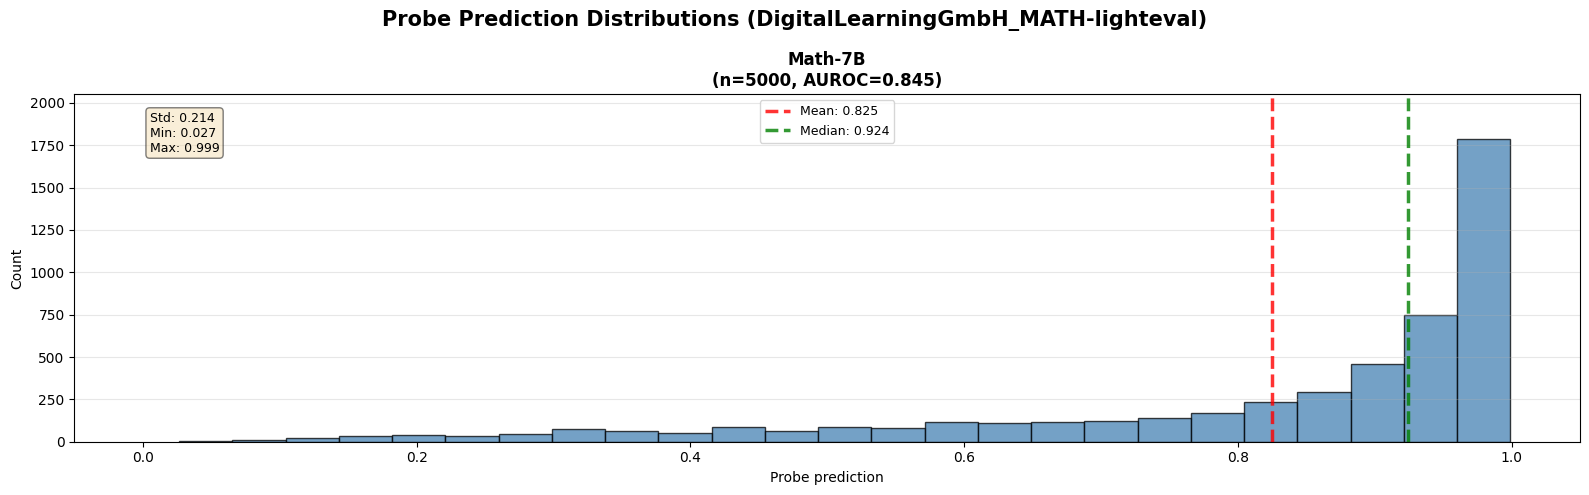

In [6]:
# ── Probe-prediction histograms (non-fallback models) ──────
fig = plot_probe_histograms(
    test_dfs_with_probes, CASCADE_MODELS[:-1],
    chosen_metric=CHOSEN_METRIC,
    dataset_name=ROUTED_DATASET,
)
plt.show()

In [7]:
# ── Threshold sweep ────────────────────────────────────────
n_thresholds = len(CASCADE_MODELS) - 1

# Build threshold grid automatically
if n_thresholds == 1:
    threshold_grid = [(t,) for t in np.arange(0.1, 1.0, 0.1)]
elif n_thresholds == 2:
    from itertools import product
    threshold_grid = list(product(np.arange(0.3, 1.0, 0.1), repeat=2))
else:
    threshold_grid = [tuple([t] * n_thresholds) for t in np.arange(0.3, 1.0, 0.1)]

print(f"Cascade depth: {n_thresholds} escalation(s)")
print(f"Sweeping {len(threshold_grid)} threshold combinations ...\n")

cascade_results = {}
for th in threshold_grid:
    cascade_results[th] = route_cascade_threshold(
        test_dfs_with_probes, CASCADE_MODELS, CHOSEN_METRIC,
        thresholds=th, tier_costs_dict=tier_costs,
    )

# Summary
for th, df in sorted(cascade_results.items()):
    esc = df["escalations"].value_counts().sort_index()
    desc = ", ".join(f"esc={k}: {v}" for k, v in esc.items())
    print(f"  {th}  →  acc={df[CHOSEN_METRIC].mean():.3f}, cost=${df['total_output_cost_usd'].sum():.2f}  [{desc}]")

print(f"\n✓ {len(cascade_results)} cascade variants generated")

Cascade depth: 1 escalation(s)
Sweeping 9 threshold combinations ...

  (np.float64(0.1),)  →  acc=0.828, cost=$3.48  [esc=0: 4985, esc=1: 15]
  (np.float64(0.2),)  →  acc=0.836, cost=$4.18  [esc=0: 4901, esc=1: 99]
  (np.float64(0.30000000000000004),)  →  acc=0.842, cost=$4.83  [esc=0: 4806, esc=1: 194]
  (np.float64(0.4),)  →  acc=0.855, cost=$5.91  [esc=0: 4641, esc=1: 359]
  (np.float64(0.5),)  →  acc=0.870, cost=$6.94  [esc=0: 4445, esc=1: 555]
  (np.float64(0.6),)  →  acc=0.882, cost=$8.03  [esc=0: 4205, esc=1: 795]
  (np.float64(0.7000000000000001),)  →  acc=0.895, cost=$8.85  [esc=0: 3924, esc=1: 1076]
  (np.float64(0.8),)  →  acc=0.906, cost=$9.66  [esc=0: 3549, esc=1: 1451]
  (np.float64(0.9),)  →  acc=0.914, cost=$10.63  [esc=0: 2814, esc=1: 2186]

✓ 9 cascade variants generated


In [8]:
# ── Baselines: random & oracle ─────────────────────────────
routed_random = route_random(
    test_dfs_with_probes, CASCADE_MODELS, CHOSEN_METRIC, random_seed=42,
)
routed_oracle = route_oracle_cascade(
    test_dfs_with_probes, CASCADE_MODELS, CHOSEN_METRIC,
    tier_costs_dict=tier_costs,
)

print(f"Random  — acc {routed_random[CHOSEN_METRIC].mean():.3f}, cost ${routed_random['total_output_cost_usd'].sum():.2f}")
print(f"Oracle  — acc {routed_oracle[CHOSEN_METRIC].mean():.3f}, cost ${routed_oracle['total_output_cost_usd'].sum():.2f}")

Random  — acc 0.869, cost $7.32
Oracle  — acc 0.943, cost $6.36


In [9]:
# ── Assemble comparison data ───────────────────────────────
comparison_data = build_cascade_comparison_data(
    test_dfs_with_probes, CASCADE_MODELS, CHOSEN_METRIC,
    cascade_results=cascade_results,
    routed_random=routed_random,
    routed_oracle=routed_oracle,
)

pd.DataFrame(comparison_data).sort_values("Cost")

,Strategy,Cost,majority_vote_is_correct
0,Always Qwen/Qwen2.5-Math-7B-Instruct,3.275528,0.8274
4,"Cascade (np.float64(0.1),)",3.479726,0.8280
5,"Cascade (np.float64(0.2),)",4.183090,0.8356
6,"Cascade (np.float64(0.30000000000000004),)",4.827374,0.8424
7,"Cascade (np.float64(0.4),)",5.910071,0.8550
3,Oracle,6.362574,0.9426
8,"Cascade (np.float64(0.5),)",6.943407,0.8702
2,Random Routing,7.318705,0.8686
9,"Cascade (np.float64(0.6),)",8.032774,0.8816
10,"Cascade (np.float64(0.7000000000000001),)",8.849808,0.8950


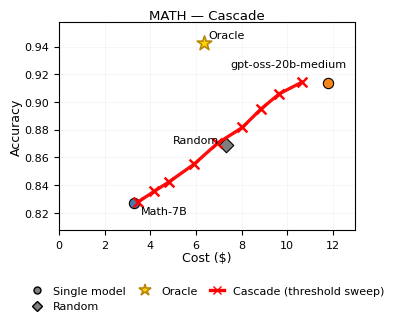

In [10]:
# ── Pareto plot ────────────────────────────────────────────
LABEL_TWEAKS = {
    "Math-7B":              dict(dx=5,   dy=-10),
    "R1-Qwen-7B":           dict(dx=-40, dy=5),
    "gpt-oss-20b-medium":   dict(dx=-70, dy=10),
    "gpt-oss-20b-low":      dict(dx=-6,  dy=5),
    "gpt-oss-20b-high":     dict(dx=6,   dy=5, ha="right"),
}

fig, ax = plot_cost_vs_accuracy_cascade(
    comparison_data,
    metric_col=CHOSEN_METRIC,
    title=f"{dataset_title(ROUTED_DATASET)} — Cascade",
    xscale="auto",
    robust_xlim=False,
    label_tweaks=LABEL_TWEAKS,
    frontier_highlight_k=7,
)
# fig.savefig(f"../figs/{ROUTED_DATASET}_cascade_pareto.png", dpi=400, bbox_inches="tight", pad_inches=0.02)
plt.show()

In [11]:
# ── Best cascade strategies ────────────────────────────────
cascade_df = pd.DataFrame(comparison_data)
cascade_only = cascade_df[cascade_df["Strategy"].str.startswith("Cascade")].sort_values("Cost")

print("All cascade variants (sorted by cost):\n")
for _, row in cascade_only.iterrows():
    print(f"  {row['Strategy']:30s}  acc={row[CHOSEN_METRIC]:.4f}  cost=${row['Cost']:.4f}")

# Best trade-off: within 1% of max accuracy, lowest cost
max_acc = cascade_only[CHOSEN_METRIC].max()
near_best = cascade_only[cascade_only[CHOSEN_METRIC] >= max_acc * 0.99]
best = near_best.nsmallest(1, "Cost").iloc[0]
print(f"\n✓ Best trade-off: {best['Strategy']}  (acc={best[CHOSEN_METRIC]:.4f}, cost=${best['Cost']:.4f})")

All cascade variants (sorted by cost):

  Cascade (np.float64(0.1),)      acc=0.8280  cost=$3.4797
  Cascade (np.float64(0.2),)      acc=0.8356  cost=$4.1831
  Cascade (np.float64(0.30000000000000004),)  acc=0.8424  cost=$4.8274
  Cascade (np.float64(0.4),)      acc=0.8550  cost=$5.9101
  Cascade (np.float64(0.5),)      acc=0.8702  cost=$6.9434
  Cascade (np.float64(0.6),)      acc=0.8816  cost=$8.0328
  Cascade (np.float64(0.7000000000000001),)  acc=0.8950  cost=$8.8498
  Cascade (np.float64(0.8),)      acc=0.9060  cost=$9.6596
  Cascade (np.float64(0.9),)      acc=0.9142  cost=$10.6258

✓ Best trade-off: Cascade (np.float64(0.8),)  (acc=0.9060, cost=$9.6596)
